# load libraries and prepare workspace

In [1]:
# load genomearray repository, many functions used below are from this library
import sys, os
sys.path.append(os.path.relpath('/home/notebooks/culviner/dropbox_link/repositories/genomearray3/'))
import genomearray3 as ga
import Bio.SeqIO as SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
## load the mg1655 genome (version U00096_2)
mg1655_genome = SeqIO.read('MG1655.gbk', 'genbank')
## load a table of gene information (downloaded from ecocyc.org)
mg1655_gt = pd.read_csv('MG1655_gt.csv', index_col=0)
# extract coding regions
coding_regions = mg1655_gt.loc[mg1655_gt.ncbi_type == 'CDS', ['strand','start','end']].values.astype(int)
# extract coding region names
coding_names = mg1655_gt.index[mg1655_gt.ncbi_type == 'CDS'].values.astype(str)
# remove toxins, antitoxins and flu gene
remove_genes = ['flu',
                'mazF','mazE',
                'chpB','chpS',
                'hicA','hicB',
                'mqsR','mqsA',
                'relE','relB',
                'yoeB','yefM',
                'yhaV','prlF',
                'higB','higA',
                'yafO','yafN',
                'yafQ','dinJ',]
final_gene_list_mask = ~np.isin(coding_names,remove_genes)
coding_names   = coding_names[final_gene_list_mask]
coding_regions = coding_regions[final_gene_list_mask]
# get a coding mask
coding_mask = ga.regionstomask(coding_regions, len(mg1655_genome))

In [2]:
# prepare matplotlib settings to output figures
figure_output_path = 'jupyter_out/'
params = {'axes.titlesize':11,
          'xtick.labelsize':9,
          'ytick.labelsize':9,
          'axes.labelsize': 10}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['pdf.fonttype'] = 42
sns.set_style(style='ticks')
yellow_black_blue = sns.diverging_palette(230, 65, l=80, as_cmap=True, center="dark")

# load and normalize sequencing data, calculate cleavage ratios and slopes

Data is depth-normalized for any pairs on which cleavage ratios (or cleavage ratio slopes) are calculated.

In [3]:
# load MazF expression data (5 minute expression)
full_path = 'numpy_data/'
file_name = ['79s1_unique.npy',
             '79s2_unique.npy',
             '80s1_unique.npy',
             '80s2_unique.npy',]
# now do
(fd_79_ev1, fd_79_ev2,
 fd_80_mazf1, fd_80_mazf2) = ga.loadarrays([full_path+fn for fn in file_name],
                                                normalization=ga.mediandensitynormalization,
                                                log2=True, regions=coding_regions)
fd_79_ev = np.mean([fd_79_ev1, fd_79_ev2], axis=0)
fd_80_mazf = np.mean([fd_80_mazf1, fd_80_mazf2], axis=0)

# calculate cleavage ratios for MazF and empty vectors
cr_79_ev1 = fd_79_ev1 - fd_79_ev2
cr_79_ev2 = fd_79_ev2 - fd_79_ev1
cr_80_mazf = fd_80_mazf - fd_79_ev
cr_80_mazf1 = fd_80_mazf1 - fd_79_ev1
cr_80_mazf2 = fd_80_mazf2 - fd_79_ev2

In [4]:
# load toxin expression data (10 minute expression)
full_path = 'numpy_data/'
file_name = ['94_ev1.npy',
             '94_ev2.npy',
             '178_chpB.npy',
             '179_hicA.npy',
             '180_yhaV.npy',
             '181_mqsR.npy',
             '183_relE.npy',
             '184_yoeB.npy',
             '185_yafO.npy',
             '187_higB.npy',]
(fd_94_ev1, fd_94_ev2, fd_178_chpB, fd_179_hicA,
 fd_180_yhaV, fd_181_mqsR, fd_183_relE,
 fd_184_yoeB, fd_185_yafO, fd_187_higB) = ga.loadarrays([full_path+fn for fn in file_name],
                                                        normalization=ga.mediandensitynormalization,
                                                        log2=True, regions=coding_regions)

fd_94_ev = np.mean([fd_94_ev1, fd_94_ev2], axis=0)

# calculate cleavage ratios for each toxin expression data set
cr_94_ev1   = fd_94_ev1 - fd_94_ev2
cr_94_ev2   = fd_94_ev2 - fd_94_ev1
cr_178_chpB = fd_178_chpB - fd_94_ev
cr_179_hicA = fd_179_hicA - fd_94_ev
cr_180_yhaV = fd_180_yhaV - fd_94_ev
cr_181_mqsR = fd_181_mqsR - fd_94_ev
cr_183_relE = fd_183_relE - fd_94_ev
cr_184_yoeB = fd_184_yoeB - fd_94_ev
cr_185_yafO = fd_185_yafO - fd_94_ev
cr_187_higB = fd_187_higB - fd_94_ev

In [5]:
# load MazF titration data
full_path = 'numpy_data/'
# load and normalize data
file_name = [
    '190628_titrlow_ev.npy',
    '190628_titrmid_ev.npy',
    '190628_titrlow_mazf.npy',
    '190628_titrmid_mazf.npy',]
# define fragment densities
(fd_low_ev, fd_mid_ev, fd_low_mazf, fd_mid_mazf,) = ga.loadarrays([full_path+fn for fn in file_name],
                                                        normalization=ga.mediandensitynormalization,
                                                        log2=True, regions=coding_regions)
cr_mid_ev = fd_mid_ev - fd_low_ev
cr_low_mazf = fd_low_mazf - fd_low_ev
cr_mid_mazf = fd_mid_mazf - fd_mid_ev

In [6]:
# load michele's chlor treatment data
full_path = 'numpy_data/'
# load and normalize data
file_name = ['mlr_wt_chlor_15.npy',
             'mlr_wt_chlor_30.npy',
             'mlr_wt_chlor_60.npy',
             'mlr_d10_chlor_15.npy',
             'mlr_d10_chlor_30.npy',
             'mlr_d10_chlor_60.npy',]

# define fragment densities
(fd_mlr_wt_chlor_15, fd_mlr_wt_chlor_30, fd_mlr_wt_chlor_60,
 fd_mlr_d10_chlor_15, fd_mlr_d10_chlor_30, fd_mlr_d10_chlor_60,
                                ) = ga.loadarrays([full_path+fn for fn in file_name],
                                                   normalization=ga.mediandensitynormalization,
                                                   log2=True, regions=coding_regions)

cr_mlr_chlor_15 = fd_mlr_wt_chlor_15 - fd_mlr_d10_chlor_15
cr_mlr_chlor_30 = fd_mlr_wt_chlor_30 - fd_mlr_d10_chlor_30
cr_mlr_chlor_60 = fd_mlr_wt_chlor_60 - fd_mlr_d10_chlor_60

In [7]:
# load revision data: heat shock and mix of empty vector and MazF
full_path = 'numpy_data/'
# load and normalize data
file_name = ['hs_wt_15m.npy',
             'hs_wt_30m.npy', # 30 minute data was not used in analyses as showed evidence of poor quality RNA
             'hs_wt_60m.npy',
             'hs_d10_15m.npy',
             'hs_d10_30m.npy', # ^ see above
             'hs_d10_60m.npy',
             'mix_100ev.npy',
             'mix_99ev.npy',
             'mix_95ev.npy',
             'mix_90ev.npy',
             'mix_0ev.npy',]

# define fragment densities
(hs_wt_15m, hs_wt_30m, hs_wt_60m, hs_d10_15m, hs_d10_30m, hs_d10_60m,
 mix_100ev, mix_99ev, mix_95ev, mix_90ev, mix_0ev, ) = ga.loadarrays([full_path+fn for fn in file_name],
                                                   normalization=ga.mediandensitynormalization,
                                                   log2=True, regions=coding_regions)

cr_hs_15m  = hs_wt_15m - hs_d10_15m
cr_hs_30m  = hs_wt_30m - hs_d10_30m
cr_hs_60m  = hs_wt_60m - hs_d10_60m
cr_100mazf = mix_0ev - mix_100ev
cr_10mazf  = mix_90ev - mix_100ev
cr_5mazf   = mix_95ev - mix_100ev
cr_1mazf   = mix_99ev - mix_100ev

Cleavage ratio slopes are calculated across 30-bp regions.

In [8]:
# calculate rolling slopes
# control data
crs_80_mazf  = ga.ntmath.rollingslope(cr_80_mazf, 30, '5_prime')
crs_80_mazf1 = ga.ntmath.rollingslope(cr_80_mazf1, 30, '5_prime')
crs_80_mazf2 = ga.ntmath.rollingslope(cr_80_mazf2, 30, '5_prime')
crs_mid_mazf  = ga.ntmath.rollingslope(cr_mid_mazf, 30, '5_prime')
crs_low_mazf  = ga.ntmath.rollingslope(cr_low_mazf, 30, '5_prime')
crs_79_ev1    = ga.ntmath.rollingslope(cr_79_ev1, 30, '5_prime')
# data for Michele's paper v1
crs_178_chpB     = ga.ntmath.rollingslope(cr_178_chpB, 30, '5_prime')
crs_179_hicA     = ga.ntmath.rollingslope(cr_179_hicA, 30, '5_prime')
crs_181_mqsR     = ga.ntmath.rollingslope(cr_181_mqsR, 30, '5_prime')
crs_183_relE     = ga.ntmath.rollingslope(cr_183_relE, 30, '5_prime')
crs_184_yoeB     = ga.ntmath.rollingslope(cr_184_yoeB, 30, '5_prime')
crs_180_yhaV     = ga.ntmath.rollingslope(cr_180_yhaV, 30, '5_prime')
crs_187_higB     = ga.ntmath.rollingslope(cr_187_higB, 30, '5_prime')
crs_185_yafO     = ga.ntmath.rollingslope(cr_185_yafO, 30, '5_prime')
crs_mlr_chlor_15 = ga.ntmath.rollingslope(cr_mlr_chlor_15, 30, '5_prime')
crs_mlr_chlor_30 = ga.ntmath.rollingslope(cr_mlr_chlor_30, 30, '5_prime')
crs_mlr_chlor_60 = ga.ntmath.rollingslope(cr_mlr_chlor_60, 30, '5_prime')
# data for revision
crs_hs_15m  = ga.ntmath.rollingslope(cr_hs_15m, 30, '5_prime')
crs_hs_60m  = ga.ntmath.rollingslope(cr_hs_60m, 30, '5_prime')
crs_100mazf = ga.ntmath.rollingslope(cr_100mazf, 30, '5_prime')
crs_10mazf  = ga.ntmath.rollingslope(cr_10mazf, 30, '5_prime')
crs_5mazf   = ga.ntmath.rollingslope(cr_5mazf, 30, '5_prime')
crs_1mazf   = ga.ntmath.rollingslope(cr_1mazf, 30, '5_prime')

# Functions for this manuscript

Functions used extensively below in analyses, but not general enough to be added to the repository.

In [9]:
def identifyconsideredgenes(input_regions, fragment_densities, minimum_density_thresholds, verbose=True, mask=False, addl_nt=(0,0)):
    meets_minimums = [np.asarray(ga.regionfunc(np.min, input_regions, fd_array, addl_nt=addl_nt)) >= fd_minimum
                                 for fd_array, fd_minimum in zip(fragment_densities, minimum_density_thresholds)]
    meets_minimums_region_mask = np.all(meets_minimums, axis=0)
    output_regions = np.asarray(input_regions)[meets_minimums_region_mask]
    if verbose:
        print('n initial regions: %i\nexpressed regions: %i'%(len(input_regions), len(output_regions)))
    if mask == False:
        return output_regions
    if mask == True:
        return meets_minimums_region_mask

def randomsampler(input_data, sample_size, n_cycles):
    return np.asarray([np.random.choice(input_data, size=sample_size, replace=False) for i in range(n_cycles)])

def percentiletest(control_cr, test_cr, expression_fragment_densities, expression_minimum_thresholds,
                   test_statistic, percentile, n_cycles, below=True, addl_nt=(0,0)):
    # determine expressed regions
    expressed_regions = identifyconsideredgenes(coding_regions, expression_fragment_densities, expression_minimum_thresholds, verbose=False, addl_nt=addl_nt)
    # next calculate the test statistic on expressed regions on the experimental and non-experimental genes
    control_output = np.asarray(ga.regionfunc(test_statistic, expressed_regions, control_cr))
    test_output    = np.asarray(ga.regionfunc(test_statistic, expressed_regions, test_cr))
    # determine threshold based on input percentile
    statistic_threshold = np.percentile(control_output, percentile)
    if below:
        target_mask = control_output < statistic_threshold # make a mask of target genes on the control set
    else:
        target_mask = control_output > statistic_threshold # make a mask of target genes on the control set
    sample_size = target_mask.sum()
    # what are the values on the test sample - how do they compare to random samples?
    test_sample_target = np.mean(test_output[target_mask])
    test_sample_randomdist = np.mean(randomsampler(test_output, sample_size, n_cycles),axis=1)
    test_sample_randomdist_mean = np.mean(test_sample_randomdist)
    test_sample_randomdist_std  = np.std(test_sample_randomdist)
    return test_sample_target, test_sample_randomdist_mean, test_sample_randomdist_std, test_sample_randomdist

# Figure 3D

MazF z-score: 16.08
chl 15m z-score: -1.97
chl 30m z-score: -0.01
chl 60m z-score: 0.89


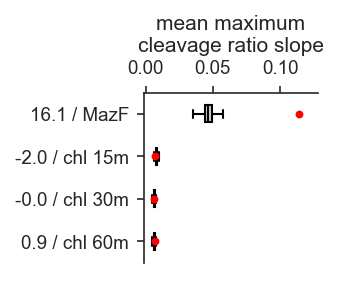

In [25]:
#            | title info        | control CR| test CR    |  expression FDs                               |
data_sets = [['MazF',    crs_80_mazf1, crs_80_mazf2,      [fd_79_ev1, fd_80_mazf1, fd_79_ev2, fd_80_mazf2]],
             ['chl 15m', crs_80_mazf,  crs_mlr_chlor_15,  [fd_79_ev, fd_80_mazf, fd_mlr_d10_chlor_15, fd_mlr_wt_chlor_15]],
             ['chl 30m', crs_80_mazf,  crs_mlr_chlor_30,  [fd_79_ev, fd_80_mazf, fd_mlr_d10_chlor_30, fd_mlr_wt_chlor_30]],
             ['chl 60m', crs_80_mazf,  crs_mlr_chlor_60,  [fd_79_ev, fd_80_mazf, fd_mlr_d10_chlor_60, fd_mlr_wt_chlor_60]],]

########### PLOTTING SECTION ###########
fig,ax = plt.subplots(figsize=(1.5,1.5))
pos = 0
z_scores = []
ax.set_xlabel('mean maximum\ncleavage ratio slope')
ax.xaxis.set_label_position('top') 
########################################
for title, ctl_cr, tst_cr, exp_fd in data_sets:
    # run using data sets provided above
    target, rnd_mean, rnd_std, rnd_dist = percentiletest(control_cr = ctl_cr,
                                                         test_cr = tst_cr,
                                                         expression_fragment_densities = exp_fd,
                                                         expression_minimum_thresholds = np.log2([64, 1, 64, 1]),
                                                         test_statistic = np.max,
                                                         percentile = 95,
                                                         n_cycles = 10000,
                                                         below = False, addl_nt=(0,30))
    z_score = (target-rnd_mean)/rnd_std
    z_scores.append(z_score)
    print('%s z-score: %.2f'%(title,z_score))
    
    ######## PLOTTING SECTION ##########
    # plot target mean as a single point
    plt.scatter([target],[pos],color='r',s=7.5,zorder=15)
    # plot distribution of random samples
    box = plt.boxplot(rnd_dist, positions=[pos], vert=False,
                      widths=[.4],showfliers=True,patch_artist=True,
                      medianprops={'linewidth':1,'zorder':10,'color':'k'},
                      whiskerprops={'linewidth':1,'linestyle':'-','color':'k'},
                      capprops={'linewidth':1,'linestyle':'-','color':'k'},
                      flierprops={'alpha':0})
    box['boxes'][0].set(facecolor='#d3d3d3',zorder=5,linewidth=1)
    pos -= 1 # update boxplot position
ax.set_ylim(pos+.5,.5)
sns.despine(top=False,bottom=True,left=False,right=True)
ax.xaxis.tick_top()
plt.yticks(-np.arange(len(data_sets)), ['%.1f / '%(z)+row[0] for z,row in zip(z_scores,data_sets)])
None
####################################
fig.savefig('Fig_3D.pdf',format='pdf',bbox_inches='tight',dpi=300)

# Figure 3E

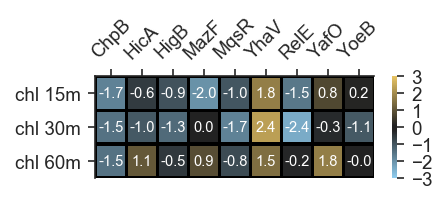

In [26]:
# multi-row version to pull z-scores only
ctl_sets = [['ChpB', crs_178_chpB, fd_94_ev, fd_178_chpB],
            ['HicA', crs_179_hicA, fd_94_ev, fd_179_hicA],
            ['HigB', crs_187_higB, fd_94_ev, fd_187_higB],
            ['MazF', crs_80_mazf,  fd_79_ev, fd_80_mazf ],
            ['MqsR', crs_181_mqsR, fd_94_ev, fd_181_mqsR],
            ['YhaV', crs_180_yhaV, fd_94_ev, fd_180_yhaV],
            ['RelE', crs_183_relE, fd_94_ev, fd_183_relE],
            ['YafO', crs_185_yafO, fd_94_ev, fd_185_yafO],
            ['YoeB', crs_184_yoeB, fd_94_ev, fd_184_yoeB],]

output_matrix = []
for toxin_name, toxin_cr, ctl_ev_fd, ctl_tx_fd in ctl_sets:
    #            | title info| control CR| test CR         |  expression FDs                                              |
    data_sets = [['chl 15m', toxin_cr, crs_mlr_chlor_15,  [ctl_ev_fd, ctl_tx_fd, fd_mlr_d10_chlor_15, fd_mlr_wt_chlor_15]],
                 ['chl 30m', toxin_cr, crs_mlr_chlor_30,  [ctl_ev_fd, ctl_tx_fd, fd_mlr_d10_chlor_30, fd_mlr_wt_chlor_30]],
                 ['chl 60m', toxin_cr, crs_mlr_chlor_60,  [ctl_ev_fd, ctl_tx_fd, fd_mlr_d10_chlor_60, fd_mlr_wt_chlor_60]],]
    output_column = []
    for title, ctl_cr, tst_cr, exp_fd in data_sets:
        # run using data sets provided above
        target, rnd_mean, rnd_std, rnd_dist = percentiletest(control_cr = ctl_cr,
                                                             test_cr = tst_cr,
                                                             expression_fragment_densities = exp_fd,
                                                             expression_minimum_thresholds = np.log2([64, 1, 64, 1]),
                                                             test_statistic = np.max,
                                                             percentile = 95,
                                                             n_cycles = 10000,
                                                             below = False, addl_nt=(0,30))
        z_score = (target-rnd_mean)/rnd_std
        output_column.append(z_score)
    output_matrix.append(output_column)
output_matrix = np.asarray(output_matrix)
# now plot the output
fig,ax = plt.subplots(1,1,figsize=(3,.9))
# all genes
output_df = pd.DataFrame(data=output_matrix.T, index=[row[0] for row in data_sets], columns=[row[0] for row in ctl_sets])
heatmap = sns.heatmap(output_df, vmin=-3, vmax=3,
                      ax=ax, cmap=yellow_black_blue, cbar=True,  linewidths=1, linecolor='k',
                      annot=True,fmt='.1f',annot_kws={'fontsize':7})
sns.despine(ax=ax,top=False,bottom=True,)
plt.xticks(rotation=45)
None
####################################
fig.savefig('Fig_3E.pdf',format='pdf',bbox_inches='tight',dpi=300)

# Figure S5A

100% MazF z-score: 8.18
10% MazF z-score: 5.12
5% MazF z-score: 1.02
1% MazF z-score: 0.17


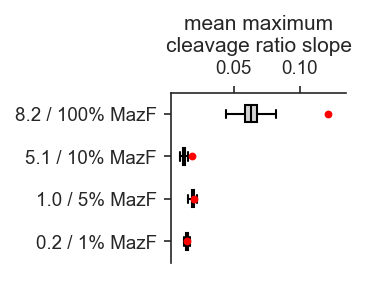

In [27]:
#            | title info | control CR | test CR    | expression FDs                               |
data_sets = [['100% MazF', crs_80_mazf,  crs_100mazf,  [fd_79_ev, fd_80_mazf, mix_100ev, mix_0ev]],
             ['10% MazF',  crs_80_mazf,  crs_10mazf,   [fd_79_ev, fd_80_mazf, mix_100ev, mix_90ev]],
             ['5% MazF',   crs_80_mazf,  crs_5mazf,    [fd_79_ev, fd_80_mazf, mix_100ev, mix_95ev]],
             ['1% MazF',   crs_80_mazf,  crs_1mazf,    [fd_79_ev, fd_80_mazf, mix_100ev, mix_99ev]],]

########### PLOTTING SECTION ###########
fig,ax = plt.subplots(figsize=(1.5,1.5))
pos = 0
z_scores = []
ax.set_xlabel('mean maximum\ncleavage ratio slope')
ax.xaxis.set_label_position('top') 
########################################
for title, ctl_cr, tst_cr, exp_fd in data_sets:
    # run using data sets provided above
    target, rnd_mean, rnd_std, rnd_dist = percentiletest(control_cr = ctl_cr,
                                                         test_cr = tst_cr,
                                                         expression_fragment_densities = exp_fd,
                                                         expression_minimum_thresholds = np.log2([64, 1, 64, 1]),
                                                         test_statistic = np.max,
                                                         percentile = 95,
                                                         n_cycles = 10000,
                                                         below = False, addl_nt=(0,30))
    z_score = (target-rnd_mean)/rnd_std
    z_scores.append(z_score)
    print('%s z-score: %.2f'%(title,z_score))
    
    ######## PLOTTING SECTION ##########
    # plot target mean as a single point
    plt.scatter([target],[pos],color='r',s=7.5,zorder=15)
    # plot distribution of random samples
    box = plt.boxplot(rnd_dist, positions=[pos], vert=False,
                      widths=[.4],showfliers=True,patch_artist=True,
                      medianprops={'linewidth':1,'zorder':10,'color':'k'},
                      whiskerprops={'linewidth':1,'linestyle':'-','color':'k'},
                      capprops={'linewidth':1,'linestyle':'-','color':'k'},
                      flierprops={'alpha':0})
    box['boxes'][0].set(facecolor='#d3d3d3',zorder=5,linewidth=1)
    pos -= 1 # update boxplot position
ax.set_ylim(pos+.5,.5)
sns.despine(top=False,bottom=True,left=False,right=True)
ax.xaxis.tick_top()
plt.yticks(-np.arange(len(data_sets)), ['%.1f / '%(z)+row[0] for z,row in zip(z_scores,data_sets)])
None
####################################
fig.savefig('Fig_S5A.pdf',format='pdf',bbox_inches='tight',dpi=300)

# Figure S5E

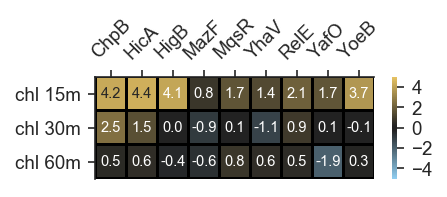

In [28]:
ctl_sets = [['ChpB', cr_178_chpB, fd_94_ev, fd_178_chpB],
            ['HicA', cr_179_hicA, fd_94_ev, fd_179_hicA],
            ['HigB', cr_187_higB, fd_94_ev, fd_187_higB],
            ['MazF', cr_80_mazf,  fd_79_ev, fd_80_mazf ],
            ['MqsR', cr_181_mqsR, fd_94_ev, fd_181_mqsR],
            ['YhaV', cr_180_yhaV, fd_94_ev, fd_180_yhaV],
            ['RelE', cr_183_relE, fd_94_ev, fd_183_relE],
            ['YafO', cr_185_yafO, fd_94_ev, fd_185_yafO],
            ['YoeB', cr_184_yoeB, fd_94_ev, fd_184_yoeB],]

output_matrix = []
for toxin_name, toxin_cr, ctl_ev_fd, ctl_tx_fd in ctl_sets:
    #            | title info| control CR| test CR         |  expression FDs                                              |
    data_sets = [['chl 15m', toxin_cr, cr_mlr_chlor_15,  [ctl_ev_fd, ctl_tx_fd, fd_mlr_d10_chlor_15, fd_mlr_wt_chlor_15]],
                 ['chl 30m', toxin_cr, cr_mlr_chlor_30,  [ctl_ev_fd, ctl_tx_fd, fd_mlr_d10_chlor_30, fd_mlr_wt_chlor_30]],
                 ['chl 60m', toxin_cr, cr_mlr_chlor_60,  [ctl_ev_fd, ctl_tx_fd, fd_mlr_d10_chlor_60, fd_mlr_wt_chlor_60]],]
    output_column = []
    for title, ctl_cr, tst_cr, exp_fd in data_sets:
        # run using data sets provided above
        target, rnd_mean, rnd_std, rnd_dist = percentiletest(control_cr = ctl_cr,
                                                             test_cr = tst_cr,
                                                             expression_fragment_densities = exp_fd,
                                                             expression_minimum_thresholds = np.log2([64, 1, 64, 1]),
                                                             test_statistic = np.min,
                                                             percentile = 20,
                                                             n_cycles = 10000)
#         print('%s %s: %.2f,%.2f,%.2f'%(toxin_name, title, target, rnd_mean, rnd_std))
        z_score = (target-rnd_mean)/rnd_std
        output_column.append(z_score)
    output_matrix.append(output_column)
output_matrix = np.asarray(output_matrix)
# now plot the output
fig,ax = plt.subplots(1,1,figsize=(3,.9))
# all genes
output_df = pd.DataFrame(data=output_matrix.T, index=[row[0] for row in data_sets], columns=[row[0] for row in ctl_sets])
heatmap = sns.heatmap(output_df, vmin=-5, vmax=5,
                      ax=ax, cmap=yellow_black_blue, cbar=True,  linewidths=1, linecolor='k',
                      annot=True,fmt='.1f',annot_kws={'fontsize':7})
sns.despine(ax=ax,top=False,bottom=True,)
plt.xticks(rotation=45)
None
####################################
fig.savefig('Fig_S5E.pdf',format='pdf',bbox_inches='tight',dpi=300)

# Figure S5H

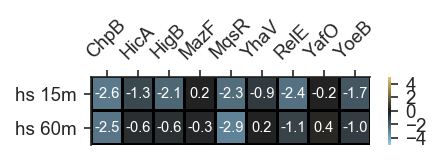

In [29]:
ctl_sets = [['ChpB', crs_178_chpB, fd_94_ev, fd_178_chpB],
            ['HicA', crs_179_hicA, fd_94_ev, fd_179_hicA],
            ['HigB', crs_187_higB, fd_94_ev, fd_187_higB],
            ['MazF', crs_80_mazf,  fd_79_ev, fd_80_mazf ],
            ['MqsR', crs_181_mqsR, fd_94_ev, fd_181_mqsR],
            ['YhaV', crs_180_yhaV, fd_94_ev, fd_180_yhaV],
            ['RelE', crs_183_relE, fd_94_ev, fd_183_relE],
            ['YafO', crs_185_yafO, fd_94_ev, fd_185_yafO],
            ['YoeB', crs_184_yoeB, fd_94_ev, fd_184_yoeB],]

output_matrix = []
for toxin_name, toxin_cr, ctl_ev_fd, ctl_tx_fd in ctl_sets:
    #            | title info| control CR| test CR         |  expression FDs                                              |
    data_sets = [['hs 15m', toxin_cr, crs_hs_15m,  [ctl_ev_fd, ctl_tx_fd, hs_d10_15m, hs_wt_15m]],
                 ['hs 60m', toxin_cr, crs_hs_60m,  [ctl_ev_fd, ctl_tx_fd, hs_d10_60m, hs_wt_60m]],]
    output_column = []
    for title, ctl_cr, tst_cr, exp_fd in data_sets:
        # run using data sets provided above
        target, rnd_mean, rnd_std, rnd_dist = percentiletest(control_cr = ctl_cr,
                                                             test_cr = tst_cr,
                                                             expression_fragment_densities = exp_fd,
                                                             expression_minimum_thresholds = np.log2([64, 1, 64, 1]),
                                                             test_statistic = np.max,
                                                             percentile = 95,
                                                             n_cycles = 10000,
                                                             below = False, addl_nt=(0,30))
        z_score = (target-rnd_mean)/rnd_std
        output_column.append(z_score)
    output_matrix.append(output_column)
output_matrix = np.asarray(output_matrix)
# now plot the output
fig,ax = plt.subplots(1,1,figsize=(3,.6))
# all genes
output_df = pd.DataFrame(data=output_matrix.T, index=[row[0] for row in data_sets], columns=[row[0] for row in ctl_sets])
heatmap = sns.heatmap(output_df, vmin=-5, vmax=5,
                      ax=ax, cmap=yellow_black_blue, cbar=True,  linewidths=1, linecolor='k',
                      annot=True,fmt='.1f',annot_kws={'fontsize':7})
sns.despine(ax=ax,top=False,bottom=True,)
plt.xticks(rotation=45)
####################################
fig.savefig('Fig_S5H.pdf',format='pdf',bbox_inches='tight',dpi=300)

# Figure S5I

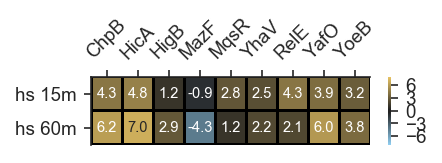

In [30]:
ctl_sets = [['ChpB', cr_178_chpB, fd_94_ev, fd_178_chpB],
            ['HicA', cr_179_hicA, fd_94_ev, fd_179_hicA],
            ['HigB', cr_187_higB, fd_94_ev, fd_187_higB],
            ['MazF', cr_80_mazf,  fd_79_ev, fd_80_mazf ],
            ['MqsR', cr_181_mqsR, fd_94_ev, fd_181_mqsR],
            ['YhaV', cr_180_yhaV, fd_94_ev, fd_180_yhaV],
            ['RelE', cr_183_relE, fd_94_ev, fd_183_relE],
            ['YafO', cr_185_yafO, fd_94_ev, fd_185_yafO],
            ['YoeB', cr_184_yoeB, fd_94_ev, fd_184_yoeB],]

output_matrix = []
for toxin_name, toxin_cr, ctl_ev_fd, ctl_tx_fd in ctl_sets:
    #            | title info| control CR| test CR         |  expression FDs                                              |
    data_sets = [['hs 15m', toxin_cr, cr_hs_15m,  [ctl_ev_fd, ctl_tx_fd, hs_d10_15m, hs_wt_15m]],
                 ['hs 60m', toxin_cr, cr_hs_60m,  [ctl_ev_fd, ctl_tx_fd, hs_d10_60m, hs_wt_60m]],]
    output_column = []
    for title, ctl_cr, tst_cr, exp_fd in data_sets:
        # run using data sets provided above
        target, rnd_mean, rnd_std, rnd_dist = percentiletest(control_cr = ctl_cr,
                                                             test_cr = tst_cr,
                                                             expression_fragment_densities = exp_fd,
                                                             expression_minimum_thresholds = np.log2([64, 1, 64, 1]),
                                                             test_statistic = np.min,
                                                             percentile = 20,
                                                             n_cycles = 10000)
#         print('%s %s: %.2f,%.2f,%.2f'%(toxin_name, title, target, rnd_mean, rnd_std))
        z_score = (target-rnd_mean)/rnd_std
        output_column.append(z_score)
    output_matrix.append(output_column)
output_matrix = np.asarray(output_matrix)
# now plot the output
fig,ax = plt.subplots(1,1,figsize=(3,.6))
# all genes
output_df = pd.DataFrame(data=output_matrix.T, index=[row[0] for row in data_sets], columns=[row[0] for row in ctl_sets])
heatmap = sns.heatmap(output_df, vmin=-8, vmax=8,
                      ax=ax, cmap=yellow_black_blue, cbar=True,  linewidths=1, linecolor='k',
                      annot=True,fmt='.1f',annot_kws={'fontsize':7})
sns.despine(ax=ax,top=False,bottom=True,)
plt.xticks(rotation=45)
####################################
fig.savefig('Fig_S5I.pdf',format='pdf',bbox_inches='tight',dpi=300)